# How to make a search engine on Movies Description

In this notebook, you will learn how to :

1. [Create a Doc2Vec model that represents words and documents into numerical vectors](#creating)

2. [Find words related to other words](#words)
3. [Find the document that has the closest meaning to a list of key words like in a search engine](#docs)

4. [Create a TF-IDF search engine](#tfidf)



<div class="alert alert-warning">
To run this notebook, you will need :
<ul>
<li>to run on **python 3.6.2**</li>
<li>to have **gensim** installed. Run '**pip install gensim**' in the python environment you are using for this notebook.</li>
<li>to have **langdetect** installed. Run '**pip install langdetect**' in the python environment you are using for this notebook.</li>
</ul>

</div>

We will start by importing what we need and downloading the files with the movies description.

The dataset comes from a kaggle dataset : https://www.kaggle.com/rounakbanik/the-movies-dataset/data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from gensim.models import Doc2Vec
from collections import namedtuple
import gensim.utils
from langdetect import detect
import re
import string

C:\Users\Paul\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
imdbdata=pd.read_csv('movies.csv')
data = np.array(imdbdata.overview)
titles=np.array(imdbdata.original_title)

imdbdata.head()

,overview,original_title
0,"Led by Woody, Andy's toys live happily in his ...",Toy Story
1,When siblings Judy and Peter discover an encha...,Jumanji
2,A family wedding reignites the ancient feud be...,Grumpier Old Men
3,"Cheated on, mistreated and stepped on, the wom...",Waiting to Exhale
4,Just when George Banks has recovered from his ...,Father of the Bride Part II


## Text preprocessing

In order to build the doc2vec model we need to clean the data that we have. We will remove documents that are not strings, that are too short and that are not written in english.
Then, we will remove punctuation, and lowercase every word.
We will build the list **alldocs** that contains every documents cleaned.

In [3]:
SentimentDocument = namedtuple('SentimentDocument', 'words tags title original_number')
n=0
alldocs = []  # Will hold all docs in original order

regex = re.compile('[%s]' % re.escape(string.punctuation)) #to remove punctuation

for line_no, line in enumerate(data):
    if (type(line)==str):
        if (len(line)>150):
            if (detect(line) == 'en') :
                line = regex.sub('', line)
                tokens = gensim.utils.to_unicode(line).lower().split()
                words = tokens[0:]
                tags = [n]
                title = titles[line_no]
                alldocs.append(SentimentDocument(words, tags, title, line_no))
                n=n+1    

Some insights on the dataset :

Number of Documents :  34179
Mean length of documents :  65.9082770122


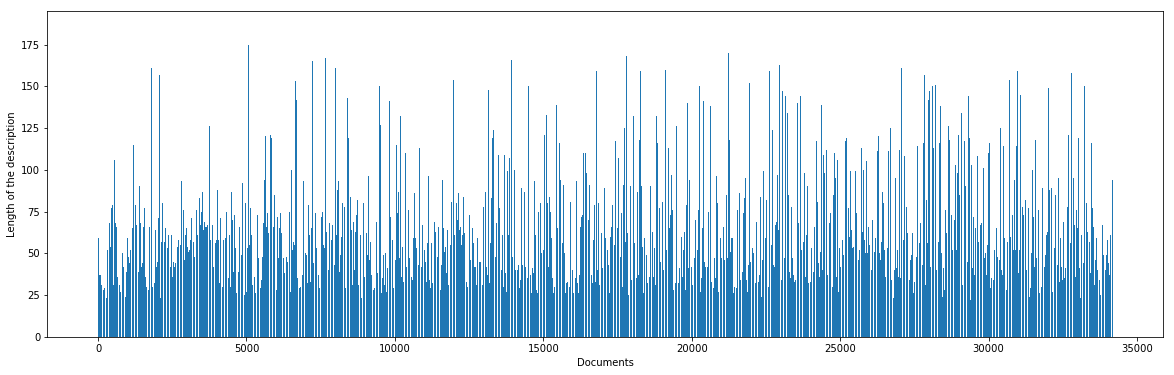

In [4]:
l = []
for doc in alldocs:
    l.append(len(doc.words))

print('Number of Documents : ', len(alldocs))
print('Mean length of documents : ', np.mean(l))

plt.figure (figsize=(20, 6))
plt.bar(range(0, len(l)), l)
plt.xlabel('Documents')
plt.ylabel('Length of the description')

In [5]:
# An example of how the list alldocs is build

index = 0
doc = alldocs[index]
print(doc, '\n')
print(data[doc.original_number])

SentimentDocument(words=['led', 'by', 'woody', 'andys', 'toys', 'live', 'happily', 'in', 'his', 'room', 'until', 'andys', 'birthday', 'brings', 'buzz', 'lightyear', 'onto', 'the', 'scene', 'afraid', 'of', 'losing', 'his', 'place', 'in', 'andys', 'heart', 'woody', 'plots', 'against', 'buzz', 'but', 'when', 'circumstances', 'separate', 'buzz', 'and', 'woody', 'from', 'their', 'owner', 'the', 'duo', 'eventually', 'learns', 'to', 'put', 'aside', 'their', 'differences'], tags=[0], title='Toy Story', original_number=0) 

Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.


## <a id="creating"></a> Creating and training the Doc2Vec model

We create the Distributed Memory model with a size of 300 ( that means that the vectors will be of size 300). The window size is 10. We do not take in account words that are seen less than 10 times in the entire corpus with the variable *min_count*. Setting the variable *dbow_words* to 1 means that we are also training to represents words with numerical vectors.

We then train our model over 100 epochs with a lerning rate of 0.01.

Full documentation can be found here :
<li> gensim : https://radimrehurek.com/gensim/ </li>
<li> Doc2Vec : https://radimrehurek.com/gensim/models/doc2vec.html </li>
<li> A great article introducing the concepts behind Doc2Vec : https://medium.com/scaleabout/a-gentle-introduction-to-doc2vec-db3e8c0cce5e </li>
<li> Detailed scientific paper : https://cs.stanford.edu/~quocle/paragraph_vector.pdf </li>


In [6]:
# PV-DM
model = Doc2Vec(dm=1, size=300,window=10,hs=0,min_count=10,dbow_words=1,sample=1e-5)

# build the vocabulary 
model.build_vocab(alldocs)

In [7]:
model.train(alldocs, total_examples=model.corpus_count, epochs=100, start_alpha=0.01, end_alpha=0.01)

61857051

We can save and load models with the lines below.

In [8]:
model.save("model")
#Doc2Vec.load("model")

## <a id="words"></a>Evaluating words embedding

We will evaluate our model with some examples by showing the closest words to the words love, war and space.

As the process of training a neural network does not always come to the same model, if the results do not make sense, you might consider creating the model and training it again.



In [9]:
model.wv.most_similar_cosmul(positive = ["love"])

[('falls', 0.8415920734405518),
 ('fall', 0.8223381042480469),
 ('falling', 0.809511661529541),
 ('madly', 0.805092453956604),
 ('triangle', 0.7625957131385803),
 ('longing', 0.7604942321777344),
 ('loves', 0.7585750222206116),
 ('unrequited', 0.7567517757415771),
 ('fallen', 0.7561032176017761),
 ('starcrossed', 0.7486485838890076)]

In [10]:
model.wv.most_similar_cosmul(positive = ["war"])

[('ii', 0.916086733341217),
 ('civil', 0.8646630048751831),
 ('ww', 0.8290786147117615),
 ('soldier', 0.8284476399421692),
 ('trenches', 0.8215895295143127),
 ('frontline', 0.8129386305809021),
 ('soldiers', 0.803424060344696),
 ('wwii', 0.8010735511779785),
 ('gis', 0.8008193373680115),
 ('wwi', 0.798528254032135)]

In [11]:
model.wv.most_similar_cosmul(positive = ["space"])

[('planet', 0.905954122543335),
 ('earth', 0.8947596549987793),
 ('astronaut', 0.8946824073791504),
 ('mars', 0.8890441060066223),
 ('astronauts', 0.8849765658378601),
 ('outer', 0.8825117349624634),
 ('spacecraft', 0.8823702335357666),
 ('asteroid', 0.8799456357955933),
 ('spaceship', 0.872674286365509),
 ('nasa', 0.868364691734314)]

The cell below show that the relationship of gender is understood by the model as we almost have the equation ** man - woman = king - queen**

In [12]:
model.wv.most_similar_cosmul(negative = ["man"], positive = ["king","woman"])

[('princess', 0.8492944836616516),
 ('queen', 0.847778856754303),
 ('empress', 0.8453134298324585),
 ('throne', 0.8132423162460327),
 ('betrothed', 0.8092519640922546),
 ('dartagnan', 0.8028621077537537),
 ('prince', 0.8018682599067688),
 ('motherhood', 0.7944889664649963),
 ('musketeers', 0.7898212671279907),
 ('ursula', 0.7872051000595093)]

The results on the word embeddings are satisfying as we have coherent outputs.

## <a id="docs"></a>Evaluating documents embedding

We will evaluate our model of documents embedding with some examples by showing the closest documents to key words ( here called tokens). We expect the documents to have similar meanings than the key words. In this way, the model act as a search engine.

In [13]:
# Closest document to the word "war"

tokens = "war"

new_vector = model.infer_vector(tokens.split() ,alpha=0.001 ,steps = 5)
tagsim = model.docvecs.most_similar([new_vector])[0]

docsim = alldocs[tagsim[0] ]

print("Document : ", data[docsim.original_number], "\n")
print("Titre : ", docsim.title)
print("Distance : ", tagsim[1])

Document :  Thriller about Guy Luthan (Hugh Grant), a British doctor working at a hospital in New York who starts making unwanted enquiries when the body of a man who died in his emergency room disappears. The trail leads Luthan to the door of the eminent surgeon Dr Lawrence Myrick (Gene Hackman), but Luthan soon finds himself under in danger from people who want the hospital's secret to remain undiscovered. 

Titre :  Extreme Measures
Distance :  0.20360776782035828


We show the closest document to the key words, the farest document and a document in the middle.

In [14]:
# Closest document to the word "love"

tokens = "love"

new_vector = model.infer_vector(tokens.split() ,alpha=0.001 ,steps = 5)
sims = model.docvecs.most_similar([new_vector], topn=model.docvecs.count) # get *all* similar documents

print("Most : " , data[alldocs[sims[0][0]].original_number], "\n") 
print("Median : " , data[alldocs[sims[17000][0]].original_number], "\n")
print("Least : " , data[alldocs[sims[-1][0]].original_number])

Most :  This mini-series focuses on two people, Tracy Whitney and Jeff Stevens. In the beginning, Tracy was an innocent, who was in love and pregnant, with the son of an affluent family. Obviously her family did not approve of her. She would sent ot prison for a crime she didn't commit. Eventually, she got released. She then set out to get back at the people who framed her. She would try to rebuild her life but her prison record would always be a hindrance. She would be offered a job, stealing jewelry. Jeff is con-man who thought he found true love, but when he learned that his wife did not feel about him as he did, decided to con some of her friends and divorce her. Their paths would cross when Tracy after stealing what she was contracted to, meets up with some policemen, one of whom is Jeff. Apparently her boss tried to double cross her but she manages to outwit them. 

Median :  After graduation, five friends set out to make a difference in the world for God. Their ambitions are hig

In this example, in terms of reviewer tone, movie genre, etc... the MOST cosine-similar documents seem more like the key words than the MEDIAN or LEAST

In [15]:
doc = np.random.randint(model.docvecs.count)

sims = model.docvecs.most_similar(doc, topn=model.docvecs.count) # get *all* similar documents

print("Target : ", data[alldocs[doc] .original_number], "\n" )
print("Most : " , data[alldocs[sims[0][0]].original_number], "\n")
print("Median : " , data[alldocs[sims[34000][0]].original_number], "\n")
print("Least : " , data[alldocs[sims[-1][0]].original_number])


Target :  Culloden is a 1964 docudrama written and directed by Peter Watkins for BBC TV. It portrays the 1746 Battle of Culloden that resulted in the British Army's destruction of the Scottish Jacobite uprising and, in the words of the narrator, "tore apart forever the clan system of the Scottish Highlands". Described in its opening credits as "an account of one of the most mishandled and brutal battles ever fought in Britain", Culloden was hailed as a breakthrough for its cinematography as well as its use of non-professional actors and its presentation of an historical event in the style of modern TV war reporting. The film was based on John Prebble's study of the battle. 

Most :  A dramatized account of a great Russian naval mutiny and a resulting street demonstration which brought on a police massacre. The film had an incredible impact on the development of cinema and was a masterful example of montage editing. 

Median :  Five maids in São Paulo are observed in this episodic, impr

Usually the MOST cosine-similar documents usually seem more like the TARGET than the MEDIAN or LEAST

 ## Pre-trained word embeddings
 
 It is possible to use pre-trained word embeddings for your model. Indeed, there is a word2vec model available here (https://code.google.com/archive/p/word2vec). This model is trained by google but might not be well suited for the problem you want to solve. 

In [16]:
# PV-DBOW (with negative sampling)
model_pre_trained = Doc2Vec(dm=0,size=300, window=15,hs=0,negative=5,min_count=10,dbow_words=1,sample=1e-5)

# build the vocabulary 
model_pre_trained.build_vocab(alldocs)

# use pre-trained word vectors from google
model_pre_trained.intersect_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [17]:
model_pre_trained.train(alldocs, total_examples=model.corpus_count, epochs=100)

61854690

## <a id="tfidf"></a>Creating the TF-IDF model

We create the TF-IDF model from the list alldocs with the module TfidfModel from gensim.


Full documentation can be found here :
<li> gensim : https://radimrehurek.com/gensim/ </li>
<li> Tf-Idf : https://radimrehurek.com/gensim/models/tfidfmodel.html </li>

In [18]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim import similarities 

dct = Dictionary(doc.words for doc in alldocs)  # fit dictionary
corpus = [dct.doc2bow(line.words) for line in alldocs]  # convert dataset to BoW format
model_tfidf = TfidfModel(corpus)  # fit model

In [19]:
# for example 
 
index = 0
print("Document ",index, " : ", data[alldocs[index].original_number] ) 
print("Bag of words representation of document ", index, " : ", corpus[index])

Document  0  :  Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.
Bag of words representation of document  0  :  [(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1), (6, 1), (7, 1), (8, 3), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 2), (35, 1), (36, 1), (37, 1), (38, 1), (39, 3)]


## Creating Similarity matrix between a list of key words and all the documents

We create a matrix similarity thet represents the similarity between the list of key words and the documents.

In [20]:
#Create similarity matrix between doc and tokens
tokens = "love".split()
index = similarities.MatrixSimilarity([dct.doc2bow(tokens)],num_features=len(dct))

We just use the document with the higher score of similarity.

In [21]:
similarity=np.zeros((len(alldocs)))
maxsim = 0
for id, doc in enumerate(alldocs):
    similarity[id] = index[dct.doc2bow(doc.words)]
    
docsim= alldocs[np.argmax(similarity)] 
print(data[docsim.original_number])
print(tagsim)
print(docsim.title)

Out of Love encapsulates the sweltering and devastating dynamics of love in the turbulent relationship between Varya and Nikolai, where genuine love and hope contend with destruction and despair.
(791, 0.20360776782035828)
Out of Love


The output is coherent with the input as there is the word **love** 3 times in the document.

# Conclusion 

There are a lot of differences between the Doc2Vec search engine and the TF-IDF search engine. The TF-IDF model look only for the words listed in the key words that matches with the words in the document. This model is performing only if you look for documents that matches exactly the list of key words. But this model do not take into account the meaning of the words and the semantic proximity that can exist between 2 words. That is what is trying to achieve the Doc2Vec model. The goal is to create a model that represents meaning similarity between words and documents. The downside is that the model is more complex to create and depends on the data that is given and the tuning of hyper-parameters.